In [31]:
# Author: Robert Guthrie

# Les % permettent le reload de modules et participe à l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import des librairies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
'''
Préparation des mots pour l'entrainement
:param seq: mot à convertir en index
:param to_ix: dico avec les index
:return: tensor contenant l'index du mot
'''
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[seq]]
    return torch.tensor(idxs, dtype=torch.long)

'''
Affiche deux graphiques
:param losses_eval: tableau de loss du set d'evaluation/validation du model
:param losses_train: tableau de loss du set d'entrainement du model
'''
def affiche(losses_eval, losses_train):
    plt.plot(np.arange(0,len(losses_eval)),losses_eval)
    plt.title('Evolution loss evaluation set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(np.arange(0,len(losses_train)),losses_train)
    plt.title('Evolution loss train set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

'''
Calcule le temps d'une epoch
:param start_time: debut du chrono
:param end_time: fin du chrono
'''
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

'''
Calcule la precision par epoch, n.b. si il y a 8/10, on retourne 0.8, non pas 8
:param preds: la prediction du model
:param y: la bonne reponse
'''
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True) # index de la valeur max
    return max_preds.eq(y)

In [94]:
##### Preparation des donnees #####

data_file = open('pos_reference.txt.lima', 'r')
data = []
word_to_ix = {} 
tag_to_ix = {}

for line in data_file : 
    # Pour ne pas prendre les lignes vides
    if not line.isspace():

        # On retire les retours chariots à la fin des lignes + separation du mot et de sa forme morpho-syntaxique dans un tuple
        wordAndToken = line.rstrip('\n').split('\t')

        # Si le mot n'est pas dans le dico on l'ajoute avec son index qui est la taille actuelle du dico
        if wordAndToken[0] not in word_to_ix:
            word_to_ix[wordAndToken[0]] = len(word_to_ix)

        # Pareil pour les tokens
        if wordAndToken[1] not in tag_to_ix:
            tag_to_ix[wordAndToken[1]] = len(tag_to_ix)

        data.append(wordAndToken)

print("Taille des dico : [words : " + str(len(word_to_ix)) + ", tags : " + str(len(tag_to_ix)) + "]")


Taille des dico : [words : 2998, tags : 21]


In [81]:
##### Separation des donnees pour l'entrainement, l'evaluation et le test ######
nb_line = len(data)
line_80 = round((nb_line*80)/100)
line_10 = round((nb_line*10)/100)  

trainSet = data[:line_80]
testSet = data[line_80+1:line_80+line_10]
evalSet = data[line_80+line_10+1:]

trainShape = np.shape(trainSet)
testShape = np.shape(testSet)
evalShape = np.shape(evalSet)

print("Train Set shape : " + str(trainShape))
print("Test Set shape : " + str(testShape))
print("Eval Set shape : " + str(evalShape))

Train Set shape : (8059, 2)
Test Set shape : (1006, 2)
Eval Set shape : (1007, 2)


In [82]:
#Chargement des donnees de GloVe
emmbed_dict = {}
embedding_dim = 50
path = '../../../glove.6B.50d.txt' #mettre le path des mots de Glove
with open(path,'r', encoding = "UTF-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

#Création et remplissage de la matrice des poids
'''
Pour chaque mot du vocabulaire de l’ensemble de données, nous vérifions s’il est sur le vocabulaire de GloVe. 
S’il le fait, nous chargeons son vecteur de mots pré-entraîné. 
Sinon, nous initialisons un vecteur aléatoire.
'''

matrix_len = len(word_to_ix)
print(matrix_len)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(word_to_ix):
    try: 
        weights_matrix[i] = emmbed_dict[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

#Conversion en tensor pour l'embedding
weight = torch.FloatTensor(weights_matrix)

print(words_found)
      

2998
2064


In [83]:
##### Creation du model avec embbeding (mots non pre-entrainne) #####
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


##### Creation du model avec embbeding (mots pre-entrainne avec Glove) #####
class LSTMTaggerGLove(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, weight):
        super(LSTMTaggerGLove, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.load_state_dict({'weight': weight}) #de taille vocab_size, donc marche pas

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [114]:
'''
Fonction d'entrainement pour un model passé en paramètre
:param model: model a entrainer
:param nb_epoch: nombre d'epoque de l'entrainement
:return losses_train & losses_eval: tableaux d'erreurs
'''
def train(model, optimizer, loss_function):
    epoch_loss = 0.0
    epoch_acc = 0

    model.train()
    for word, tag in trainSet:

        optimizer.zero_grad()
        
        wordIdx = prepare_sequence(word, word_to_ix)
        target = prepare_sequence(tag, tag_to_ix)
        
        tag_scores = model(wordIdx)

        loss = loss_function(tag_scores, target)
        epoch_loss += loss.item()

        acc = categorical_accuracy(tag_scores, target)
        epoch_acc += acc.item()

        loss.backward()

        optimizer.step()
    
    
    #optimizer.zero_grad()

    return epoch_loss/len(trainSet), epoch_acc/len(trainSet)



In [115]:
#On passe le model en phase d'evaluation
def evaluate(model, loss_function, setIterator):
    epoch_loss = 0.0
    epoch_acc = 0

    model.eval() 
    with torch.no_grad():
        for word, tag in setIterator:

            wordIdx = prepare_sequence(word, word_to_ix)
            target = prepare_sequence(tag, tag_to_ix)

            tag_scores = model(wordIdx)
            
            loss_eval = loss_function(tag_scores, target)
            epoch_loss += loss_eval.item()  
            acc = categorical_accuracy(tag_scores, target)
            epoch_acc += acc.item()
            
    
    return epoch_loss/len(setIterator), epoch_acc/len(setIterator)
        
            

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 1.105 | Train Acc: 65.49%
	 Val. Loss: 1.114 |  Val. Acc: 64.45%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.656 | Train Acc: 77.71%
	 Val. Loss: 1.096 |  Val. Acc: 67.23%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.429 | Train Acc: 85.80%
	 Val. Loss: 1.204 |  Val. Acc: 67.73%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.256 | Train Acc: 91.74%
	 Val. Loss: 1.374 |  Val. Acc: 69.22%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.149 | Train Acc: 95.67%
	 Val. Loss: 1.505 |  Val. Acc: 69.22%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.109 | Train Acc: 96.66%
	 Val. Loss: 1.459 |  Val. Acc: 70.80%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.090 | Train Acc: 96.75%
	 Val. Loss: 1.466 |  Val. Acc: 71.40%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.082 | Train Acc: 96.76%
	 Val. Loss: 1.474 |  Val. Acc: 71.60%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.077 | Train Acc: 96.76%
	 Val. Loss: 1.485 |  Val. Acc: 71.90%
Epoch: 10 | Epoch Time: 0m 

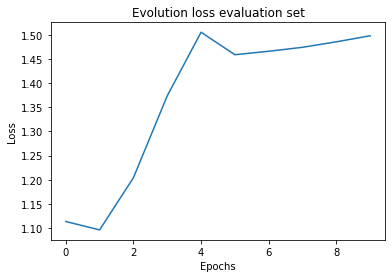

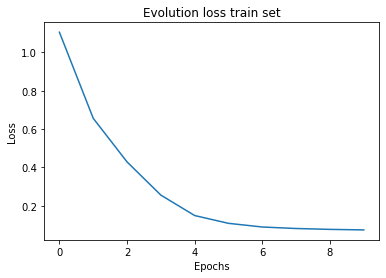

In [113]:
EMBEDDING_DIM = 50
HIDDEN_DIM = 128

################# Train the model #################
model1 = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

nb_epoch = 10
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.1)

best_valid_loss = float('inf')
train_loss_array = []
valid_loss_array = []

for epoch in range(nb_epoch):
    start_time = time.time()

    train_loss, train_acc = train(model1, optimizer, loss_function)
    valid_loss, valid_acc = evaluate(model1, loss_function, evalSet)

    end_time = time.time()
    
    train_loss_array.append(train_loss)
    valid_loss_array.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model1.state_dict(), 'model1.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print('best_valid_loss = ' + str(best_valid_loss))
affiche(valid_loss_array, train_loss_array)

In [88]:
model1.load_state_dict(torch.load('model1.pt'))

test_loss, test_acc = evaluate(model1, loss_function, testSet)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.927 |  Test Acc: 70.48%


Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.919 | Train Acc: 70.86%
	 Val. Loss: 0.868 |  Val. Acc: 68.32%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.433 | Train Acc: 85.74%
	 Val. Loss: 0.752 |  Val. Acc: 74.08%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.266 | Train Acc: 91.70%
	 Val. Loss: 0.733 |  Val. Acc: 75.37%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.167 | Train Acc: 94.95%
	 Val. Loss: 0.808 |  Val. Acc: 76.76%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.116 | Train Acc: 96.38%
	 Val. Loss: 0.850 |  Val. Acc: 76.46%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.099 | Train Acc: 96.79%
	 Val. Loss: 0.875 |  Val. Acc: 77.46%
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.085 | Train Acc: 97.00%
	 Val. Loss: 0.914 |  Val. Acc: 77.16%
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.078 | Train Acc: 97.01%
	 Val. Loss: 0.928 |  Val. Acc: 78.05%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.072 | Train Acc: 97.01%
	 Val. Loss: 0.941 |  Val. Acc: 77.86%
Epoch: 10 | Epoch Time: 0m 8

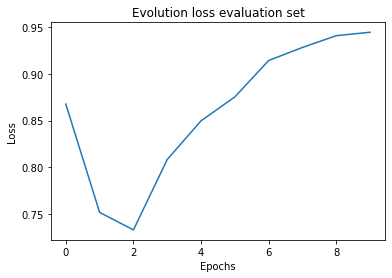

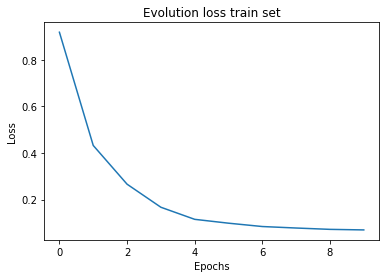

In [119]:
# Model 2
EMBEDDING_DIM = 50
HIDDEN_DIM = 128

model2 = LSTMTaggerGLove(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix), weight)

nb_epoch = 10
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.1)

best_valid_loss = float('inf')
train_loss_array = []
valid_loss_array = []

for epoch in range(nb_epoch):
    start_time = time.time()

    train_loss, train_acc = train(model2, optimizer, loss_function)
    valid_loss, valid_acc = evaluate(model2, loss_function, evalSet)

    end_time = time.time()
    
    train_loss_array.append(train_loss)
    valid_loss_array.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'model2.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print('best_valid_loss = ' + str(best_valid_loss))
affiche(valid_loss_array, train_loss_array)


In [120]:
model2.load_state_dict(torch.load('model2.pt'))

test_loss, test_acc = evaluate(model2, loss_function, testSet)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.677 |  Test Acc: 81.91%
